# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Log</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">Download the trainer pack</font>

In [1]:
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_PyTorch_Project2/refs/heads/main/trainer.zip" -O ./trainer.zip

!ls /kaggle/working/

!unzip /kaggle/working/trainer.zip

!rm /kaggle/working/trainer.zip

--2024-11-16 19:59:57--  https://raw.githubusercontent.com/RadimKozl/OpenCV_PyTorch_Project2/refs/heads/main/trainer.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28668 (28K) [application/zip]
Saving to: './trainer.zip'

./trainer.zip       100%[===================>]  28.00K  --.-KB/s    in 0.003s  

2024-11-16 19:59:57 (9.53 MB/s) - './trainer.zip' saved [28668/28668]

trainer.zip
Archive:  /kaggle/working/trainer.zip
   creating: trainer/.ipynb_checkpoints/
  inflating: trainer/.ipynb_checkpoints/base_metric-checkpoint.ipynb  
  inflating: trainer/.ipynb_checkpoints/base_metric-checkpoint.py  
  inflating: trainer/.ipynb_checkpoints/configuration-checkpoint.py  
  inflating: trainer/.ipynb_checkpoints/hooks-checkpoint.py  
  inflating: trainer/.ipynb

## <font style="color:green">Imports</font>

In [2]:
!pip install psutil
!pip install gpustat

In [3]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [4]:
%matplotlib inline


import os
import gc
import json
import csv
import yaml
import shutil
import pandas as pd
import numpy as np
import random
import time
import psutil
import gpustat
import matplotlib.pyplot as plt
import IPython
from PIL import Image

from operator import itemgetter
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torchvision.transforms import functional as F

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import MultiStepLR
from torch.nn.parallel import DataParallel

torch.multiprocessing.set_start_method('spawn', force=True)

import torchvision.models as models


from trainer import Trainer, hooks, configuration
from trainer.utils import setup_system, patch_configs
from trainer.utils import plot_normalized_confusion_matrix, id_samples
from trainer.metrics import AccuracyEstimator
from trainer.tensorboard_visualizer import TensorBoardVisualizer, ModelVisualizer, WeightsHistogramVisualizer
from trainer.tensorboard_visualizer import DataEmbedingVisualizer, PRVisualizer, ConfusionMatrixVisualizer
from trainer.tensorboard_visualizer import set_writer
from trainer.custom_dataloader import JsonClassificationDataset
from trainer.configuration import load_config_from_yaml


In [5]:
def memory_management():
    
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")
    
    memory_usage = psutil.virtual_memory()
    print(f"Memory Usage: {memory_usage.percent}%")
    
    disk_usage = psutil.disk_usage('/')
    print(f"Disk Usage: {disk_usage.percent}%")
    
    ## Get GPU statistics
    gpu_stats = gpustat.GPUStatCollection.new_query()
    
    ## Print GPU information
    for gpu in gpu_stats.gpus:
        print(f"GPU {gpu.index}: {gpu.name}, Utilization: {gpu.utilization}%")


In [6]:
memory_management()

CPU Usage: 1.0%
Memory Usage: 5.7%
Disk Usage: 73.6%
GPU 0: Tesla T4, Utilization: 0%
GPU 1: Tesla T4, Utilization: 0%


## <font style="color:green">Start TensorBoard by Ngrog tunnel</font>
<a href="https://ngrok.com/">Ngrog tunnel</a>

In [7]:
!tensorboard --version

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


2.16.2


In [8]:
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar xf ./ngrok-v3-stable-linux-amd64.tgz -C /usr/local/bin

--2024-11-16 20:01:55--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 75.2.60.68, 13.248.244.96, 35.71.179.82, ...
Connecting to bin.equinox.io (bin.equinox.io)|75.2.60.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14796857 (14M) [application/octet-stream]
Saving to: 'ngrok-v3-stable-linux-amd64.tgz'

ngrok-v3-stable-lin 100%[===================>]  14.11M  40.5MB/s    in 0.3s    

2024-11-16 20:01:55 (40.5 MB/s) - 'ngrok-v3-stable-linux-amd64.tgz' saved [14796857/14796857]



**Add to the console:**

```cmd
!ngrok authtoken <authtoken> # /root/.config/ngrok/ngrok.yml

```

In [11]:
pool = mp.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir /kaggle/working/log_resnet --load_fast=false --host 0.0.0.0 --port 6006 &",
                        "/usr/local/bin/ngrok http 6006 &"
                        ]]

In [12]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://4793-34-55-179-149.ngrok-free.app


E1116 20:02:43.377347 134856550520640 program.py:300] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


### <font style="color:blue">Class for create JSON file of datasets</font>

We create Json structure of `train`, `valid` and `test` datasets, for creating PyTorch Dataloader a standard module of `trainer`.

In [13]:
class Transform_dataset:
    def __init__(self, root_dir, save_dir, name_json_file = 'datasets.json', ratio_split_value = 80):
        self.root_dir = root_dir
        self.save_dir = save_dir
        self.name_json_file = name_json_file
        self.ratio_split_value = ratio_split_value
        self.dir_image = os.path.join(self.root_dir, 'images', 'images')
        self.train_file = os.path.join(self.root_dir, 'train.csv')
        self.test_file = os.path.join(self.root_dir, 'test.csv')
        self.sample_file = os.path.join(self.root_dir, 'sample_submission.csv')
        self.json_file = os.path.join(self.save_dir, self.name_json_file)
        self.temp_train_file = os.path.join(self.save_dir,'temp_train.csv')
        self.temp_valid_file = os.path.join(self.save_dir, 'temp_valid.csv')
        self.temp_test_file = os.path.join(self.save_dir, 'temp_test.csv')
        self.dict_name_class = {}
        self.unique_classes_train = None
        
    def __get_file_paths(self, directory):
        file_paths = []
        
        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
        return file_paths

    def __selest_class_id(self):
        train_values = pd.read_csv(self.train_file)

        class_counts_train = train_values['class'].value_counts()
        self.unique_classes_train = class_counts_train.index.tolist()
        self.unique_classes_train.sort()
       
        
        for name in self.unique_classes_train:
            self.dict_name_class[name] = int(self.unique_classes_train.index(name))

    def __train_test_split(self):
        # Load data from CSV file
        data = pd.read_csv(self.train_file)
    
        # set value for split data
        value_split = round(self.ratio_split_value/100, 2)
        
        # Get number of rows
        num_rows = len(data)
        
        # Calculate number of index of test/train data
        train_size = int(value_split * num_rows)  # 80% for training
        test_size = num_rows - train_size
        
    
        # Random index reordering
        indices = np.random.permutation(num_rows)
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]
        
        # Create training and test set using indexes
        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]
        
        # Save split data to new CSV files
        train_data.to_csv(self.temp_train_file, index=False)
        test_data.to_csv(self.temp_valid_file, index=False) 

    def __get_image_shape(self, image_path):
        img = Image.open(image_path)
        w, h = img.size
        c =  img.mode
        cc = ''
        if c == 'RGB':
            cc = 'RGB'
        elif c == 'RGBA':
            cc = 'RGBA'
        elif c == 'L':
            cc = 'Grayscale'
        elif c == '1':
            cc = 'Grayscale'
        else:
            cc = c
        return (w, h, c)

    def __correct_test_file(self):
        table_1 = pd.read_csv(self.test_file)
        table_2 = pd.read_csv(self.sample_file)
        table_test_data = pd.merge(table_1, table_2, on='id', how='left')
        table_test_data.to_csv(self.temp_test_file, index=False)

    def __remove_temp_files(self):
        os.remove(self.temp_train_file)
        os.remove(self.temp_valid_file)
        os.remove(self.temp_test_file)

    def process_json(self):
        self.__train_test_split()
        self.__correct_test_file()
        self.__selest_class_id()

        table_train = pd.read_csv(self.temp_train_file) # load csv file of train data
        table_valid = pd.read_csv(self.temp_valid_file) # load csv file of valid data
        table_test = pd.read_csv(self.temp_test_file) # load csv file of test data

        # add type data selection
        table_train['type_dataset'] = 'train'
        table_valid['type_dataset'] = 'valid'
        table_test['type_dataset'] = 'test'

        # add all data together
        df_concat_1 = pd.concat([table_train, table_valid], axis=0)
        df_concat_2 = pd.concat([df_concat_1, table_test], axis=0)

        df_concat_2['class_idx'] = df_concat_2['class'].map(self.dict_name_class)

        list_path_image = self.__get_file_paths(self.dir_image) # load path of images 

        # create table of path images
        list_id = []
        list_paths = []
        list_types = []
        list_width = []
        list_height = []
        list_channel = []
        list_idx_class = []
        for img in list_path_image:
            img_name = os.path.split(img)[1]
            img_id = int(img_name.split('.')[0])
            img_suffix = img_name.split('.')[1]
            img_data = self.__get_image_shape(img)

            list_id.append(img_id)
            list_paths.append(img)
            list_types.append(img_suffix)
            list_width.append(img_data[0])
            list_height.append(img_data[1])
            list_channel.append(img_data[2])

        # create image table data
        image_table = pd.DataFrame({
            'id': list_id, 
            'path_file': list_paths, 
            'file_type': list_types, 
            'image_width': list_width, 
            'image_height': list_height,
            'image_channel': list_channel
        })

        table_all_data = pd.merge(df_concat_2, image_table, on='id', how='left')
        num_err_val = table_all_data['path_file'].isna().sum()

        dict_data = {'datasets':[{'train':[], 'valid': [], 'test': [], 'class_number': len(self.unique_classes_train), 'names_class': self.unique_classes_train},]}

        for i in range(len(table_all_data)):
            sub_dict = {}
            main_dict = {}
            id_file = int(table_all_data.iloc[i]['id'])
            class_file = table_all_data.iloc[i]['class']
            class_idx = int(table_all_data.iloc[i]['class_idx'])
            type_dataset = table_all_data.iloc[i]['type_dataset']
            path_file = table_all_data.iloc[i]['path_file']
            file_type = table_all_data.iloc[i]['file_type']
            image_width = int(table_all_data.iloc[i]['image_width'])
            image_height = int(table_all_data.iloc[i]['image_height'])
            image_channel = table_all_data.iloc[i]['image_channel']
            name_file = str(id_file) + '.' + file_type

            sub_dict['name'] = name_file
            sub_dict['class'] = class_file
            sub_dict['clidx'] = class_idx
            sub_dict['path'] = path_file
            sub_dict['type'] = file_type
            sub_dict['width'] = image_width
            sub_dict['height'] = image_height
            sub_dict['channel'] = image_channel

            main_dict[str(id_file)] = sub_dict

            if type_dataset == 'train':
                dict_data['datasets'][0]['train'].append(main_dict)
            elif type_dataset == 'valid':
                dict_data['datasets'][0]['valid'].append(main_dict)
            elif type_dataset == 'test':
                dict_data['datasets'][0]['test'].append(main_dict)
            else:
                print(table_all_data.iloc[i], 'not add to any dataset!')

        with open(self.json_file, 'w') as f:
            json.dump(dict_data, f, indent=4)

        print(f'Data were saved to file {self.json_file}')

        self.__remove_temp_files()
        

    def return_json_address(self):
        return self.json_file

In [14]:
%%time
root_dir = os.path.join('/kaggle','input','opencv-pytorch-classification-project-2')
save_dir = os.path.join('/kaggle','working')
name_json_file = 'datasets.json'
ratio_split_value = 80

json_file = Transform_dataset(
    root_dir=root_dir, 
    save_dir=save_dir, 
    name_json_file=name_json_file, 
    ratio_split_value=ratio_split_value
)
json_file.process_json()
path_json = json_file.return_json_address()
print('Path to the JSON data structure: ', path_json)
del json_file

Data were saved to file /kaggle/working/datasets.json
Path to the JSON data structure:  /kaggle/working/datasets.json
CPU times: user 7.27 s, sys: 1.54 s, total: 8.81 s
Wall time: 47.6 s


### <font style="color:blue">Class for create custom dataloader from JSON file of datasets</font>

This is standart class of our `trainer package`. Class `JsonClassificationDataset` is inside `custom_dataloader.py` module. see: [Github - trainer package](https://github.com/RadimKozl/OpenCV_PyTorch_Project2/tree/main/trainer)

In [15]:
json_file = os.path.join('/kaggle','working','datasets.json') # /kaggle/working/datasets.json

### <font style="color:blue">Function for preview datasets</font>

In [16]:
def plot_images(loader):
    # Plot few images
    plt.rcParams["figure.figsize"] = (15, 9)
    plt.figure
    for images, labels in loader:
        for i in range(len(labels)):
            plt.subplot(3, 5, i+1)
            img = F.to_pil_image(images[i])
            plt.imshow(img)
            plt.gca().set_title('Target: {0}'.format(labels[i]))
            plt.axis('off')
        plt.show()
        break

In [17]:
base_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])

### <font style="color:blue">Create and show train dataset</font>

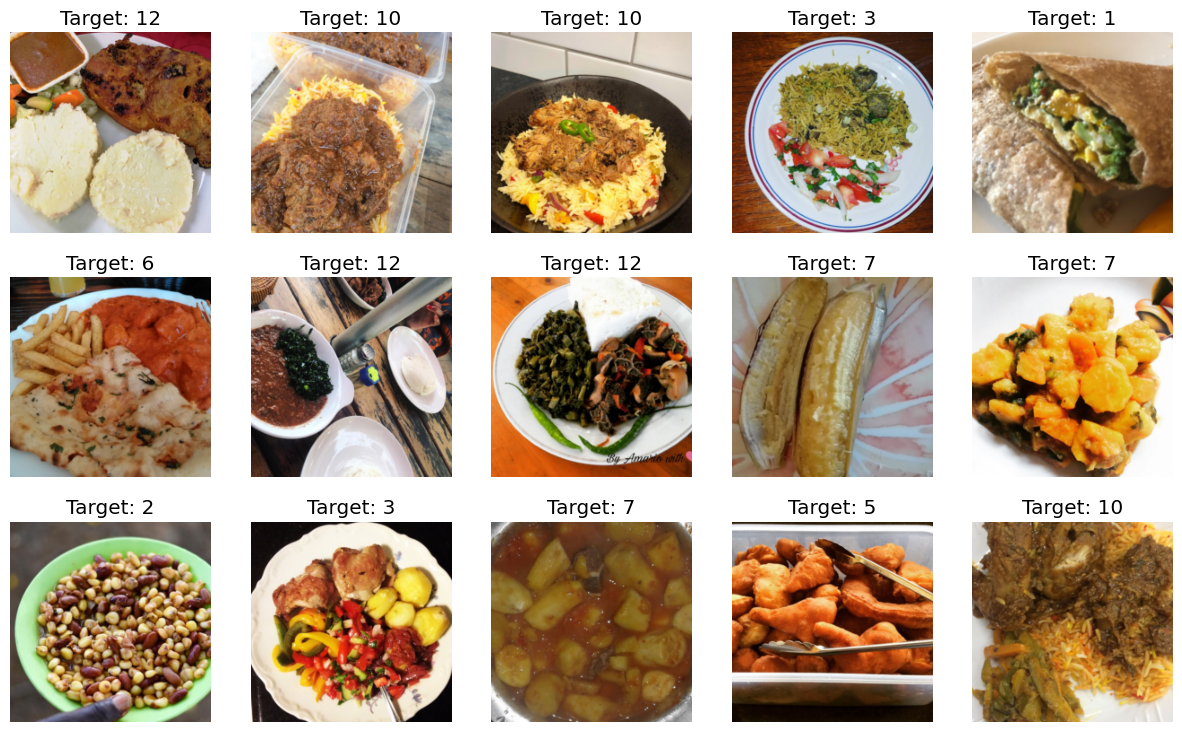

Mean: [0.56725096 0.46618392 0.36616178], Std: [0.28435631 0.28744022 0.29725166]
Number of samples of train dataset:  5228


In [18]:
train_dataset =  JsonClassificationDataset(json_file, type_data='train', dataset_number=0, transform=base_preprocess)

# dataloader with dataset
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=15,
        shuffle=True,
        num_workers=4
    )


# view dataset
plot_images(train_loader)

# mean and std values of dataset
train_norm_parameter = train_dataset.calculate_mean_std_manual()

# max number of samples of dataset
train_len_param_dataset = len(train_dataset)
print('Number of samples of train dataset: ', train_len_param_dataset)

In [19]:
name_of_classes = train_dataset.names_of_class()
print('Name of clases:\n', name_of_classes)

Name of clases:
 ['bhaji', 'chapati', 'githeri', 'kachumbari', 'kukuchoma', 'mandazi', 'masalachips', 'matoke', 'mukimo', 'nyamachoma', 'pilau', 'sukumawiki', 'ugali']


### <font style="color:blue">Create and show valid dataset</font>

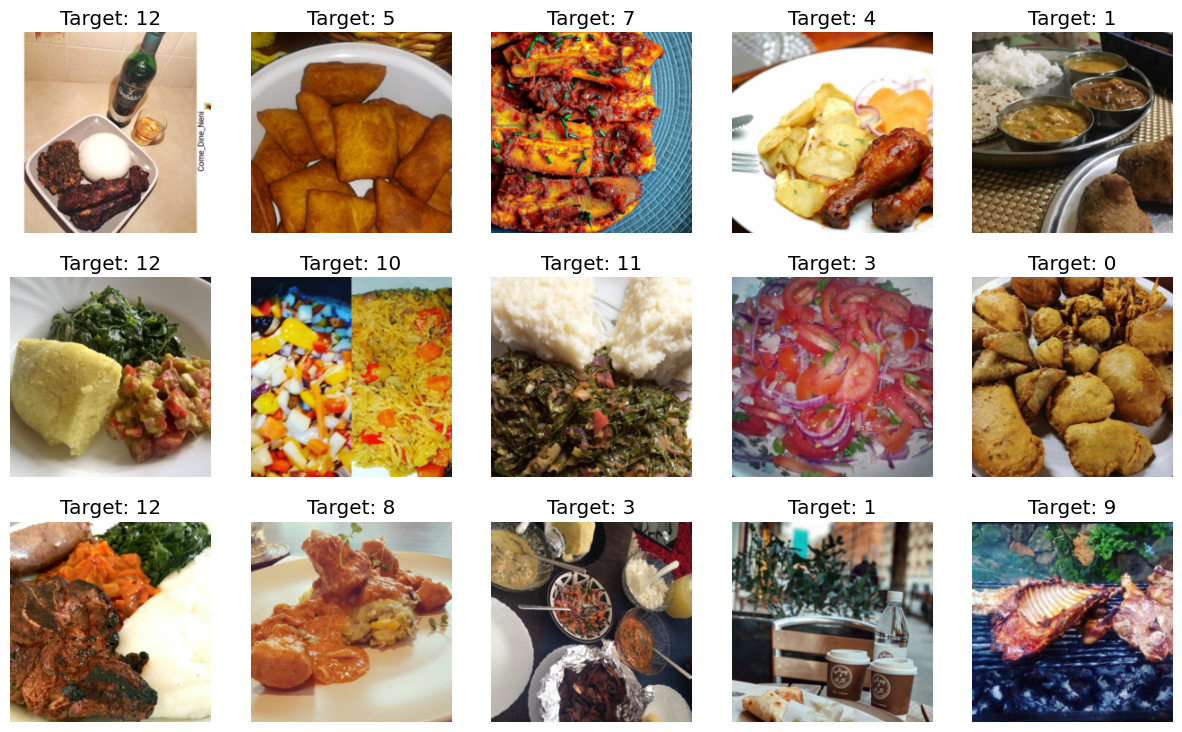

Mean: [0.56622475 0.46749339 0.36635942], Std: [0.2858253  0.28958216 0.29930797]
Number of samples of valid dataset:  1308


In [20]:
valid_dataset =  JsonClassificationDataset(json_file, type_data='valid', dataset_number=0, transform=base_preprocess)

# dataloader with dataset
valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=15,
        shuffle=True,
        num_workers=4
    )

# view dataset
plot_images(valid_loader)

# mean and std values of dataset
valid_norm_parameter = valid_dataset.calculate_mean_std_manual()

# max number of samples of dataset
valid_len_param_dataset = len(valid_dataset)
print('Number of samples of valid dataset: ', valid_len_param_dataset)
del valid_len_param_dataset, valid_norm_parameter, valid_loader

### <font style="color:blue">Create and show test dataset</font>

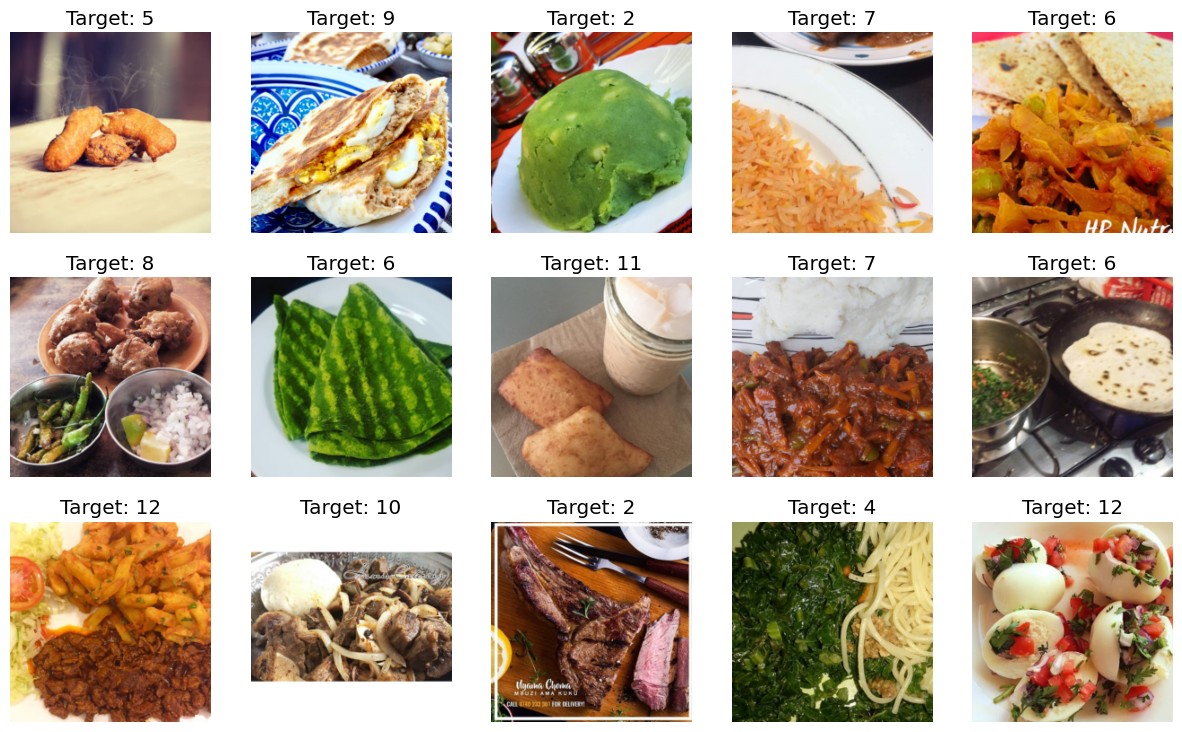

Mean: [0.56626071 0.46777388 0.36871068], Std: [0.2839786  0.28670355 0.29687443]
Number of samples of test dataset:  1638


In [21]:
test_dataset =  JsonClassificationDataset(json_file, type_data='test', dataset_number=0, transform=base_preprocess)

# dataloader with dataset
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=15,
        shuffle=True,
        num_workers=4
    )

# view dataset
plot_images(test_loader)

# mean and std values of dataset
test_norm_parameter = test_dataset.calculate_mean_std_manual()

# max number of samples of dataset
test_len_param_dataset = len(test_dataset)
print('Number of samples of test dataset: ', test_len_param_dataset)
del test_norm_parameter, test_loader

In [22]:
del base_preprocess

In [23]:
memory_management()

CPU Usage: 0.7%
Memory Usage: 7.9%
Disk Usage: 73.6%
GPU 0: Tesla T4, Utilization: 0%
GPU 1: Tesla T4, Utilization: 0%


### <font style="color:blue">Create function for get datasets for training</font>

In [24]:
def get_train_data(batch_size, writer=None, norm_parameter=None, json_file='datasets.json', num_workers=1, data_augmentation=False):
    if norm_parameter is not None:
        mean, std = norm_parameter
        # common transforms
        common_transforms = transforms.Compose([
            transforms.Resize(256), # for Resnet18, Resnet34
            transforms.CenterCrop(224), # for Resnet18, Resnet34
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        # common transforms
        common_transforms = transforms.Compose([
            transforms.Resize(256), # for Resnet18, Resnet34
            transforms.CenterCrop(224), # for Resnet18, Resnet34
            transforms.ToTensor()
        ])
        
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20, fill=(0,)),
                transforms.RandomPerspective(distortion_scale=0.6, p=1)
                #transforms.ColorJitter(brightness=.5, hue=.3)
            ]),
            common_transforms
        ])
    # else do common transforms
    else:
        train_transforms = common_transforms

    # train dataloader
    train_dataset =  JsonClassificationDataset(json_file, type_data='train', dataset_number=0, transform=train_transforms)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    

    # test dataloader
    valid_dataset =  JsonClassificationDataset(json_file, type_data='valid', dataset_number=0, transform=common_transforms)
    
    test_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

   
    if writer is not None:
        add_data_embedings = DataEmbedingVisualizer(dataset=valid_dataset, writer=writer, number_samples=50)
        add_data_embedings.update_charts()
    
    return train_loader, test_loader

### <font style="color:blue">Create function for get dataset for testing model</font>

In [25]:
def get_test_data(batch_size, norm_parameter=None, json_file='datasets.json', num_workers=1):
    
    if norm_parameter is not None:
        mean, std = norm_parameter
        # common transforms
        common_transforms = transforms.Compose([
            transforms.Resize(256), # for Resnet18, Resnet34
            transforms.CenterCrop(224), # for Resnet18, Resnet34
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        # common transforms
        common_transforms = transforms.Compose([
            transforms.Resize(256), # for Resnet18, Resnet34
            transforms.CenterCrop(224), # for Resnet18, Resnet34
            transforms.ToTensor()
        ])
        
    
    # test dataloader
    test_dataset =  JsonClassificationDataset(json_file, type_data='test', dataset_number=0, transform=common_transforms)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return test_loader

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**



### <font style="color:blue">Update configuration module of trainer</font>

We update setting of configuration classes by YAML file, see: [GitHub - configuration.py](https://github.com/RadimKozl/OpenCV_PyTorch_Project2/blob/main/trainer/configuration.py)

### <font style="color:blue">Download config file</font>

In [26]:
!mkdir /kaggle/working/models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_PyTorch_Project2/refs/heads/main/config.yaml" -O /kaggle/working/config.yaml
!mv /kaggle/working/config.yaml /kaggle/working/config_experiment_resnet18.yaml

--2024-11-16 20:12:03--  https://raw.githubusercontent.com/RadimKozl/OpenCV_PyTorch_Project2/refs/heads/main/config.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 526 [text/plain]
Saving to: '/kaggle/working/config.yaml'

/kaggle/working/con 100%[===================>]     526  --.-KB/s    in 0s      

2024-11-16 20:12:03 (20.3 MB/s) - '/kaggle/working/config.yaml' saved [526/526]



### <font style="color:blue">Update config file</font>

In [28]:
config_ex_path_resnet18 = os.path.join('/kaggle','working','config_experiment_resnet18.yaml') # path of yaml file

# load yaml file
with open(config_ex_path_resnet18, 'r') as f:
    config = yaml.safe_load(f)

In [29]:
# set system config values
config['system']['seed'] = 21
config['system']['cudnn_benchmark_enabled'] = False
config['system']['cudnn_deterministic'] = False

# set dataset config values
config['dataset']['root_dir'] = os.path.join('/','kaggle','working')
config['dataset']['json_file'] = "datasets.json"

# set dataloader config values
config['dataloader']['batch_size'] = 32
config['dataloader']['num_workers'] = 0
config['dataloader']['data_augmentation'] = True

# set optimizer config values
config['optimizer']['learning_rate'] = 0.001
config['optimizer']['momentum'] = 0.9
config['optimizer']['weight_decay'] = 0.0001
config['optimizer']['lr_step_milestones'] = [30, 40]
config['optimizer']['lr_gamma'] = 0.1

# set trainer config values
config['trainer']['model_dir'] = os.path.join('/','kaggle','working','models')
config['trainer']['model_saving_frequency'] = 1
config['trainer']['device'] = "cuda"
config['trainer']['epoch_num'] = 80
config['trainer']['log_interval'] = 5
config['trainer']['test_interval'] = 1
config['trainer']['progress_bar'] = True
config['trainer']['normalization'] = True

In [30]:
with open(config_ex_path_resnet18, 'w') as f:
    yaml.dump(config, f)

### <font style="color:blue">Load Config data from file</font>

In [31]:
system_config, dataset_config, dataloader_config, optimizer_config, trainer_config = load_config_from_yaml(config_ex_path_resnet18)

In [32]:
print('system_config\n', system_config)
print('\ndataset_config\n', dataset_config)
print('\ndataloader_config\n', dataloader_config)
print('\noptimizer_config\n', optimizer_config)
print('\ntrainer_config\n', trainer_config)

system_config
 SystemConfig(seed=21, cudnn_benchmark_enabled=False, cudnn_deterministic=False)

dataset_config
 DatasetConfig(root_dir='/kaggle/working', json_file='datasets.json', train_transforms=(ToTensor(),), test_transforms=(ToTensor(),))

dataloader_config
 DataloaderConfig(batch_size=32, num_workers=0, data_augmentation=True)

optimizer_config
 OptimizerConfig(learning_rate=0.001, momentum=0.9, weight_decay=0.0001, lr_step_milestones=(30, 40), lr_gamma=0.1)

trainer_config
 TrainerConfig(model_dir='/kaggle/working/models', model_saving_frequency=1, device='cuda', epoch_num=80, log_interval=5, test_interval=1, progress_bar=True, normalization=True)


In [33]:
memory_management()

CPU Usage: 1.0%
Memory Usage: 7.9%
Disk Usage: 73.6%
GPU 0: Tesla T4, Utilization: 0%
GPU 1: Tesla T4, Utilization: 0%


## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

We add next class to the [tensorboard_visualizer.py](https://github.com/RadimKozl/OpenCV_PyTorch_Project2/blob/main/trainer/tensorboard_visualizer.py) , class: `TensorBoardVisualizer`, `ModelVisualizer`, `DataEmbedingVisualizer`, `WeightsHistogramVisualizer`, `PRVisualizer`, `ConfusionMatrixVisualizer`

## <font style="color:green">4. Train and Validation [5 Points]</font>

**Write the methods or classes to be used for training and validation.**

These features are covered by the [trainer model](https://github.com/RadimKozl/OpenCV_PyTorch_Project2/blob/main/trainer/trainer.py), which has been modified.

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

```python
def pretrained_resnet18(transfer_learning=True, fine_tune_from_layer=False, num_class=13):
    
    """
    Load a pretrained ResNet18 model and configure it for transfer learning or fine-tuning.
    
    Args:
        transfer_learning (bool): Whether to freeze the entire model except the final layer.
        fine_tune_from_layer (bool): If True, fine-tune layers after Layer 1 (Layer 2 + FC layer).
        num_class (int): Number of output classes for the final layer.
        
    Returns:
        resnet: A modified ResNet18 model ready for transfer learning or fine-tuning.
    """
    
    # Loading the pretrained model
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    # Freeze the entire model if transfer_learning is True
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
    
    # If fine_tune_from_layer1 is True, we unlock layers after Layer 1 (ie Layer 2 and beyond)
    if fine_tune_from_layer:
        for param in resnet.layer2.parameters():  # We unblock the Layer 2 weights
            param.requires_grad = True
    
    # Replacing the last fully connected layer by the number of classes
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    # Unlocking the last layer (classifier)
    for param in resnet.fc.parameters():
        param.requires_grad = True

    return resnet
```

```python
def pretrained_resnet34(transfer_learning=True, fine_tune_from_layer=False, num_class=13):
    
    """
    Load a pretrained ResNet34 model and configure it for transfer learning or fine-tuning.
    
    Args:
        transfer_learning (bool): Whether to freeze the entire model except the final layer.
        fine_tune_from_layer (bool): If True, fine-tune layers after Layer 1 (Layer 2 + FC layer).
        num_class (int): Number of output classes for the final layer.
        
    Returns:
        resnet: A modified ResNet34 model ready for transfer learning or fine-tuning.
    """
    
    # Loading the pretrained model
    resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    
    # Freeze the entire model if transfer_learning is True
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
    
    # If fine_tune_from_layer1 is True, we unlock layers after Layer 1 (ie Layer 2 and beyond)
    if fine_tune_from_layer:
        for param in resnet.layer2.parameters():  # We unblock the Layer 2 weights
            param.requires_grad = True
    
    # Replacing the last fully connected layer by the number of classes
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    # Unlocking the last layer (classifier)
    for param in resnet.fc.parameters():
        param.requires_grad = True

    return resnet
```

In [34]:
def pretrained_resnet50(transfer_learning=True, fine_tune_from_layer=False, num_class=13):
    
    """
    Load a pretrained ResNet34 model and configure it for transfer learning or fine-tuning.
    
    Args:
        transfer_learning (bool): Whether to freeze the entire model except the final layer.
        fine_tune_from_layer (bool): If True, fine-tune layers after Layer 1 (Layer 2 + FC layer).
        num_class (int): Number of output classes for the final layer.
        
    Returns:
        resnet: A modified ResNet34 model ready for transfer learning or fine-tuning.
    """
    
    # Loading the pretrained model
    resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # Freeze the entire model if transfer_learning is True
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
    
    # If fine_tune_from_layer1 is True, we unlock layers after Layer 1 (ie Layer 2 and beyond)
    if fine_tune_from_layer:
        for param in resnet.layer2.parameters():  # We unblock the Layer 2 weights
            param.requires_grad = True
    
    # Replacing the last fully connected layer by the number of classes
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    # Unlocking the last layer (classifier)
    for param in resnet.fc.parameters():
        param.requires_grad = True

    return resnet

In [35]:
# model set for transfer learning
#model_resnet18_TL = pretrained_resnet18(transfer_learning=True, fine_tune_from_layer=False, num_class=13)
#model_resnet34_TL = pretrained_resnet34(transfer_learning=True, fine_tune_from_layer=False, num_class=13)
model_resnet50_TL = pretrained_resnet50(transfer_learning=True, fine_tune_from_layer=False, num_class=13)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s] 


In [36]:
# model set for fine tuning
#model_resnet18_FT = pretrained_resnet18(transfer_learning=False, fine_tune_from_layer=True, num_class=13)
#model_resnet34_FT = pretrained_resnet34(transfer_learning=False, fine_tune_from_layer=True, num_class=13)
model_resnet50_FT = pretrained_resnet50(transfer_learning=False, fine_tune_from_layer=True, num_class=13)


In [37]:
memory_management()

CPU Usage: 5.0%
Memory Usage: 8.7%
Disk Usage: 73.6%
GPU 0: Tesla T4, Utilization: 0%
GPU 1: Tesla T4, Utilization: 0%


## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

Additional features have been added to this module: `prediction`, `get_target_and_prob`, `get_target_and_classes_cm`, `plot_normalized_confusion_matrix`, `save_model`, `load_model`, `memory_management`, `id_samples`

In [38]:
def zip_folder_with_shutil(source_folder, output_path):
    '''Function for zip TensorBoard data'''
    shutil.make_archive(output_path, 'zip', source_folder)

In [39]:
id_test_samples = id_samples(path=os.path.join('/','kaggle','working','datasets.json'), data_type='test')

In [40]:
memory_management()

CPU Usage: 1.2%
Memory Usage: 8.7%
Disk Usage: 73.6%
GPU 0: Tesla T4, Utilization: 0%
GPU 1: Tesla T4, Utilization: 0%


## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

```python
class ExperimentResnet18TL:
    
    def __init__(
        self,
        system_config: configuration.SystemConfig = system_config,
        dataset_config: configuration.DatasetConfig = dataset_config,
        dataloader_config: configuration.DataloaderConfig = dataloader_config,
        optimizer_config: configuration.OptimizerConfig = optimizer_config
    ):
        self.model_name = 'tl_resnet18'
        self.tb_writer = set_writer(os.path.join('log_resnet',self.model_name))
        self.loader_train, self.loader_test = get_train_data(
            batch_size=dataloader_config.batch_size,
            norm_parameter = train_norm_parameter,
            data_augmentation = True,
            num_workers=dataloader_config.num_workers,
            json_file='/kaggle/working/datasets.json',
            writer=None
        )

        self.loader_test_data = get_test_data(
            batch_size=dataloader_config.batch_size, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=dataloader_config.num_workers
        )
        
        setup_system(system_config)

        self.model = model_resnet18_TL
            
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        
        self.visualizer = TensorBoardVisualizer(writer=self.tb_writer)
        self.weights_histogram_visualizer = WeightsHistogramVisualizer(writer=self.tb_writer)
        self.pr_visualizer = PRVisualizer(dataloader=self.loader_test, writer=self.tb_writer, name_classes=name_of_classes)
        self.confusion_matrix_visualizer = ConfusionMatrixVisualizer(writer=self.tb_writer, dataloader=self.loader_test, class_names=name_of_classes, normalize=True)

    def run(self, trainer_config: trainer_config) -> dict:

        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
        
        # add network graph with inputs info
        _, graph_loader = get_train_data(
            batch_size=1, 
            writer=self.tb_writer, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=0, 
            data_augmentation=True
        )
        
        images, labels = next(iter(graph_loader))
        images = images.to(trainer_config.device)
        add_network_graph_tensorboard = ModelVisualizer(self.model, images, self.tb_writer)
        add_network_graph_tensorboard.update_charts()
        
        self.loss_fn = self.loss_fn.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            weighthistogram=self.weights_histogram_visualizer,
            confusion_matrix_visualizer=self.confusion_matrix_visualizer,
            pr_visualizer=self.pr_visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir,
            model_name_prefix=self.model_name
        )

        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics


    def evaluate(self, trainer_config: trainer_config):
        model = self.model
        model_name_postfix=self.model_name + '.pt'
        model_path = os.path.join(trainer_config.model_dir, model_name_postfix)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(trainer_config.device))
        model.eval()
        device = torch.device(trainer_config.device)
        name_save = self.model_name + '_results.csv'
        save_results = os.path.join(dataset_config.root_dir,name_save)

        all_targets = []
        all_preds = []

        with open(os.path.join(dataset_config.root_dir, save_results), 'w', encoding='UTF8') as f:
            writer = csv.writer(f)
            writer.writerow(['id','class'])

            with torch.no_grad():
                for i, data in enumerate(self.loader_test_data):
                    batch_size = images.size(0)
                    sample_ids = range(i * batch_size, (i + 1) * batch_size)
                    images, targets = data
                    images = images.to(device)
                    targets = targets.to(device)

                    outputs = model(images)
                    preds = outputs.argmax(dim=1)

                    for id_sample, pred in zip(sample_ids, preds):
                        f.write(f"{id_test_samples[id_sample]},{name_of_classes[pred.item()]}\n")

                    all_targets.extend(targets.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

        plot_normalized_confusion_matrix(
            predictions=all_preds, 
            targets=all_targets, 
            class_names=name_of_classes, 
            norm=True
        )
        print(f"Results saved to {save_results}")
```

```python
class ExperimentResnet34TL:
    
    def __init__(
        self,
        system_config: configuration.SystemConfig = system_config,
        dataset_config: configuration.DatasetConfig = dataset_config,
        dataloader_config: configuration.DataloaderConfig = dataloader_config,
        optimizer_config: configuration.OptimizerConfig = optimizer_config
    ):
        self.model_name = 'tl_resnet34'
        self.tb_writer = set_writer(os.path.join('log_resnet',self.model_name))
        self.loader_train, self.loader_test = get_train_data(
            batch_size=dataloader_config.batch_size,
            norm_parameter = train_norm_parameter,
            data_augmentation = True,
            num_workers=dataloader_config.num_workers,
            json_file='/kaggle/working/datasets.json',
            writer=None
        )

        self.loader_test_data = get_test_data(
            batch_size=dataloader_config.batch_size, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=dataloader_config.num_workers
        )
        
        setup_system(system_config)

        self.model = model_resnet34_TL
            
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        
        self.visualizer = TensorBoardVisualizer(writer=self.tb_writer)
        self.weights_histogram_visualizer = WeightsHistogramVisualizer(writer=self.tb_writer)
        self.pr_visualizer = PRVisualizer(dataloader=self.loader_test, writer=self.tb_writer, name_classes=name_of_classes)
        self.confusion_matrix_visualizer = ConfusionMatrixVisualizer(writer=self.tb_writer, dataloader=self.loader_test, class_names=name_of_classes, normalize=True)

    def run(self, trainer_config: trainer_config) -> dict:

        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
        
        # add network graph with inputs info
        _, graph_loader = get_train_data(
            batch_size=1, 
            writer=self.tb_writer, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=0, 
            data_augmentation=True
        )
        
        labels = next(iter(graph_loader))
        print('test \n', images)
        images = images.to(trainer_config.device)
        add_network_graph_tensorboard = ModelVisualizer(self.model, images, self.tb_writer)
        add_network_graph_tensorboard.update_charts()
        
        self.loss_fn = self.loss_fn.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            weighthistogram=self.weights_histogram_visualizer,
            confusion_matrix_visualizer=self.confusion_matrix_visualizer,
            pr_visualizer=self.pr_visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir,
            model_name_prefix=self.model_name
        )

        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def evaluate(self, trainer_config: trainer_config):
        model = self.model
        model_name_postfix=self.model_name + '.pt'
        model_path = os.path.join(trainer_config.model_dir, model_name_postfix)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(trainer_config.device))
        model.eval()
        device = torch.device(trainer_config.device)
        name_save = self.model_name + '_results.csv'
        save_results = os.path.join(dataset_config.root_dir,name_save)

        all_targets = []
        all_preds = []

        with open(os.path.join(dataset_config.root_dir, save_results), 'w', encoding='UTF8') as f:
            writer = csv.writer(f)
            writer.writerow(['id','class'])

            with torch.no_grad():
                for i, data in enumerate(self.loader_test_data):
                    batch_size = images.size(0)
                    sample_ids = range(i * batch_size, (i + 1) * batch_size)
                    images, targets = data
                    images = images.to(device)
                    targets = targets.to(device)

                    outputs = model(images)
                    preds = outputs.argmax(dim=1)

                    for id_sample, pred in zip(sample_ids, preds):
                        f.write(f"{id_test_samples[id_sample]},{name_of_classes[pred.item()]}\n")

                    all_targets.extend(targets.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

        plot_normalized_confusion_matrix(
            predictions=all_preds, 
            targets=all_targets, 
            class_names=name_of_classes, 
            norm=True
        )
        print(f"Results saved to {save_results}")
```

In [41]:
class ExperimentResnet50TL:
    
    def __init__(
        self,
        system_config: configuration.SystemConfig = system_config,
        dataset_config: configuration.DatasetConfig = dataset_config,
        dataloader_config: configuration.DataloaderConfig = dataloader_config,
        optimizer_config: configuration.OptimizerConfig = optimizer_config
    ):
        self.model_name = 'tl_resnet50'
        self.tb_writer = set_writer(os.path.join('log_resnet',self.model_name))
        self.loader_train, self.loader_test = get_train_data(
            batch_size=dataloader_config.batch_size,
            norm_parameter = train_norm_parameter,
            data_augmentation = True,
            num_workers=dataloader_config.num_workers,
            json_file='/kaggle/working/datasets.json',
            writer=None
        )

        self.loader_test_data = get_test_data(
            batch_size=dataloader_config.batch_size, 
            norm_parameter=dataloader_config.batch_size, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=dataloader_config.num_workers
        )
        
        setup_system(system_config)

        self.model = model_resnet50_TL
            
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        
        self.visualizer = TensorBoardVisualizer(writer=self.tb_writer)
        self.weights_histogram_visualizer = WeightsHistogramVisualizer(writer=self.tb_writer)
        self.pr_visualizer = PRVisualizer(dataloader=self.loader_test, writer=self.tb_writer, name_classes=name_of_classes)
        self.confusion_matrix_visualizer = ConfusionMatrixVisualizer(writer=self.tb_writer, dataloader=self.loader_test, class_names=name_of_classes, normalize=True)

    def run(self, trainer_config: trainer_config) -> dict:

        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
        
        # add network graph with inputs info
        _, graph_loader = get_train_data(
            batch_size=1, 
            writer=self.tb_writer, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=0, 
            data_augmentation=True
        )
        
        labels = next(iter(graph_loader))
        print('test \n', images)
        images = images.to(trainer_config.device)
        add_network_graph_tensorboard = ModelVisualizer(self.model, images, self.tb_writer)
        add_network_graph_tensorboard.update_charts()
        
        self.loss_fn = self.loss_fn.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            weighthistogram=self.weights_histogram_visualizer,
            confusion_matrix_visualizer=self.confusion_matrix_visualizer,
            pr_visualizer=self.pr_visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir,
            model_name_prefix=self.model_name
        )

        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def evaluate(self, trainer_config: trainer_config):
        model = self.model
        model_name_postfix=self.model_name + '.pt'
        model_path = os.path.join(trainer_config.model_dir, model_name_postfix)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(trainer_config.device)))
        model.eval()
        device = torch.device(trainer_config.device)
        name_save = self.model_name + '_results.csv'
        save_results = os.path.join(dataset_config.root_dir,name_save)

        all_targets = []
        all_preds = []

        with open(os.path.join(dataset_config.root_dir, save_results), 'w', encoding='UTF8') as f:
            writer = csv.writer(f)
            writer.writerow(['id','class'])

            with torch.no_grad():
                for i, data in enumerate(self.loader_test_data):
                   
                    images, targets = data

                    batch_size = images.size(0)
                    sample_ids = range(i * batch_size, (i + 1) * batch_size)
                    
                    images = images.to(device)
                    targets = targets.to(device)

                    outputs = model(images)
                    preds = outputs.argmax(dim=1)

                    for id_sample, pred in zip(sample_ids, preds):
                        f.write(f"{id_test_samples[id_sample]},{name_of_classes[pred.item()]}\n")

                    all_targets.extend(targets.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

        plot_normalized_confusion_matrix(
            predictions=all_preds, 
            targets=all_targets, 
            class_names=name_of_classes, 
            norm=True
        )
        print(f"Results saved to {save_results}")

```python
class ExperimentResnet18FT:
    
    def __init__(
        self,
        system_config: configuration.SystemConfig = system_config,
        dataset_config: configuration.DatasetConfig = dataset_config,
        dataloader_config: configuration.DataloaderConfig = dataloader_config,
        optimizer_config: configuration.OptimizerConfig = optimizer_config
    ):
        self.model_name = 'ft_resnet18'
        self.tb_writer = set_writer(os.path.join('log_resnet',self.model_name))
        self.loader_train, self.loader_test = get_train_data(
            batch_size=dataloader_config.batch_size,
            norm_parameter = train_norm_parameter,
            data_augmentation = True,
            num_workers=dataloader_config.num_workers,
            json_file='/kaggle/working/datasets.json',
            writer=None
        )

        self.loader_test_data = get_test_data(
            batch_size=dataloader_config.batch_size, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=dataloader_config.num_workers
        )
        
        setup_system(system_config)

        self.model = model_resnet18_FT
            
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        
        self.visualizer = TensorBoardVisualizer(writer=self.tb_writer)
        self.weights_histogram_visualizer = WeightsHistogramVisualizer(writer=self.tb_writer)
        self.pr_visualizer = PRVisualizer(dataloader=self.loader_test, writer=self.tb_writer, name_classes=name_of_classes)
        self.confusion_matrix_visualizer = ConfusionMatrixVisualizer(writer=self.tb_writer, dataloader=self.loader_test, class_names=name_of_classes, normalize=True)

    def run(self, trainer_config: trainer_config) -> dict:

        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
        
        # add network graph with inputs info
        _, graph_loader = get_train_data(
            batch_size=1, 
            writer=self.tb_writer, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=0, 
            data_augmentation=True
        )
        
        images, labels = next(iter(graph_loader))
        images = images.to(trainer_config.device)
        add_network_graph_tensorboard = ModelVisualizer(self.model, images, self.tb_writer)
        add_network_graph_tensorboard.update_charts()
        
        self.loss_fn = self.loss_fn.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            weighthistogram=self.weights_histogram_visualizer,
            confusion_matrix_visualizer=self.confusion_matrix_visualizer,
            pr_visualizer=self.pr_visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir,
            model_name_prefix=self.model_name
        )

        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def evaluate(self, trainer_config: trainer_config):
        model = self.model
        model_name_postfix=self.model_name + '.pt'
        model_path = os.path.join(trainer_config.model_dir, model_name_postfix)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(trainer_config.device))
        model.eval()
        device = torch.device(trainer_config.device)
        name_save = self.model_name + '_results.csv'
        save_results = os.path.join(dataset_config.root_dir,name_save)

        all_targets = []
        all_preds = []

        with open(os.path.join(dataset_config.root_dir, save_results), 'w', encoding='UTF8') as f:
            writer = csv.writer(f)
            writer.writerow(['id','class'])

            with torch.no_grad():
                for i, data in enumerate(self.loader_test_data):
                    batch_size = images.size(0)
                    sample_ids = range(i * batch_size, (i + 1) * batch_size)
                    images, targets = data
                    images = images.to(device)
                    targets = targets.to(device)

                    outputs = model(images)
                    preds = outputs.argmax(dim=1)

                    for id_sample, pred in zip(sample_ids, preds):
                        f.write(f"{id_test_samples[id_sample]},{name_of_classes[pred.item()]}\n")

                    all_targets.extend(targets.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

        plot_normalized_confusion_matrix(
            predictions=all_preds, 
            targets=all_targets, 
            class_names=name_of_classes, 
            norm=True
        )
        print(f"Results saved to {save_results}")
```

```python
class ExperimentResnet34FT:
    
    def __init__(
        self,
        system_config: configuration.SystemConfig = system_config,
        dataset_config: configuration.DatasetConfig = dataset_config,
        dataloader_config: configuration.DataloaderConfig = dataloader_config,
        optimizer_config: configuration.OptimizerConfig = optimizer_config
    ):
        self.model_name = 'ft_resnet34'
        self.tb_writer = set_writer(os.path.join('log_resnet',self.model_name))
        self.loader_train, self.loader_test = get_train_data(
            batch_size=dataloader_config.batch_size,
            norm_parameter = train_norm_parameter,
            data_augmentation = True,
            num_workers=dataloader_config.num_workers,
            json_file='/kaggle/working/datasets.json',
            writer=None
        )

        self.loader_test_data = get_test_data(
            batch_size=dataloader_config.batch_size, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=dataloader_config.num_workers
        )
        
        setup_system(system_config)

        self.model = model_resnet34_FT
            
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        
        self.visualizer = TensorBoardVisualizer(writer=self.tb_writer)
        self.weights_histogram_visualizer = WeightsHistogramVisualizer(writer=self.tb_writer)
        self.pr_visualizer = PRVisualizer(dataloader=self.loader_test, writer=self.tb_writer, name_classes=name_of_classes)
        self.confusion_matrix_visualizer = ConfusionMatrixVisualizer(writer=self.tb_writer, dataloader=self.loader_test, class_names=name_of_classes, normalize=True)

    def run(self, trainer_config: trainer_config) -> dict:
        
        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
            
        # add network graph with inputs info
        _, graph_loader = get_train_data(
            batch_size=1, 
            writer=self.tb_writer, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=0, 
            data_augmentation=True
        )
            
        images, labels = next(iter(graph_loader))
        images = images.to(trainer_config.device)
        add_network_graph_tensorboard = ModelVisualizer(self.model, images, self.tb_writer)
        add_network_graph_tensorboard.update_charts()
            
        self.loss_fn = self.loss_fn.to(device)
    
        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            weighthistogram=self.weights_histogram_visualizer,
            confusion_matrix_visualizer=self.confusion_matrix_visualizer,
            pr_visualizer=self.pr_visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir,
            model_name_prefix=self.model_name
        )
    
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def evaluate(self, trainer_config: trainer_config):
        model = self.model
        model_name_postfix=self.model_name + '.pt'
        model_path = os.path.join(trainer_config.model_dir, model_name_postfix)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(trainer_config.device))
        model.eval()
        device = torch.device(trainer_config.device)
        name_save = self.model_name + '_results.csv'
        save_results = os.path.join(dataset_config.root_dir,name_save)

        all_targets = []
        all_preds = []

        with open(os.path.join(dataset_config.root_dir, save_results), 'w', encoding='UTF8') as f:
            writer = csv.writer(f)
            writer.writerow(['id','class'])

            with torch.no_grad():
                for i, data in enumerate(self.loader_test_data):
                    batch_size = images.size(0)
                    sample_ids = range(i * batch_size, (i + 1) * batch_size)
                    images, targets = data
                    images = images.to(device)
                    targets = targets.to(device)

                    outputs = model(images)
                    preds = outputs.argmax(dim=1)

                    for id_sample, pred in zip(sample_ids, preds):
                        f.write(f"{id_test_samples[id_sample]},{name_of_classes[pred.item()]}\n")

                    all_targets.extend(targets.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

        plot_normalized_confusion_matrix(
            predictions=all_preds, 
            targets=all_targets, 
            class_names=name_of_classes, 
            norm=True
        )
        print(f"Results saved to {save_results}")
```

In [42]:
class ExperimentResnet50FT:
    
    def __init__(
        self,
        system_config: configuration.SystemConfig = system_config,
        dataset_config: configuration.DatasetConfig = dataset_config,
        dataloader_config: configuration.DataloaderConfig = dataloader_config,
        optimizer_config: configuration.OptimizerConfig = optimizer_config
    ):
        self.model_name = 'ft_resnet50'
        self.tb_writer = set_writer(os.path.join('log_resnet',self.model_name))
        self.loader_train, self.loader_test = get_train_data(
            batch_size=dataloader_config.batch_size,
            norm_parameter = train_norm_parameter,
            data_augmentation = True,
            num_workers=dataloader_config.num_workers,
            json_file='/kaggle/working/datasets.json',
            writer=None
        )

        self.loader_test_data = get_test_data(
            batch_size=dataloader_config.batch_size, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=dataloader_config.num_workers
        )
        
        setup_system(system_config)

        self.model = model_resnet50_FT
            
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        
        self.visualizer = TensorBoardVisualizer(writer=self.tb_writer)
        self.weights_histogram_visualizer = WeightsHistogramVisualizer(writer=self.tb_writer)
        self.pr_visualizer = PRVisualizer(dataloader=self.loader_test, writer=self.tb_writer, name_classes=name_of_classes)
        self.confusion_matrix_visualizer = ConfusionMatrixVisualizer(writer=self.tb_writer, dataloader=self.loader_test, class_names=name_of_classes, normalize=True)

    def run(self, trainer_config: trainer_config) -> dict:
        
        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
            
        # add network graph with inputs info
        _, graph_loader = get_train_data(
            batch_size=1, 
            writer=self.tb_writer, 
            norm_parameter=train_norm_parameter, 
            json_file='/kaggle/working/datasets.json', 
            num_workers=0, 
            data_augmentation=True
        )
            
        images, labels = next(iter(graph_loader))
        images = images.to(trainer_config.device)
        add_network_graph_tensorboard = ModelVisualizer(self.model, images, self.tb_writer)
        add_network_graph_tensorboard.update_charts()
            
        self.loss_fn = self.loss_fn.to(device)
    
        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            weighthistogram=self.weights_histogram_visualizer,
            confusion_matrix_visualizer=self.confusion_matrix_visualizer,
            pr_visualizer=self.pr_visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir,
            model_name_prefix=self.model_name
        )
    
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def evaluate(self, trainer_config: trainer_config):
        model = self.model
        model_name_postfix=self.model_name + '.pt'
        model_path = os.path.join(trainer_config.model_dir, model_name_postfix)
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()
        device = torch.device(trainer_config.device)
        name_save = self.model_name + '_results.csv'
        save_results = os.path.join(dataset_config.root_dir,name_save)

        all_targets = []
        all_preds = []

        with open(os.path.join(dataset_config.root_dir, save_results), 'w', encoding='UTF8') as f:
            writer = csv.writer(f)
            writer.writerow(['id','class'])

            with torch.no_grad():
                for i, data in enumerate(self.loader_test_data):
                    
                    images, targets = data

                    batch_size = images.size(0)
                    sample_ids = range(i * batch_size, (i + 1) * batch_size)
                    
                    images = images.to(device)
                    targets = targets.to(device)

                    outputs = model(images)
                    preds = outputs.argmax(dim=1)

                    for id_sample, pred in zip(sample_ids, preds):
                        f.write(f"{id_test_samples[id_sample]},{name_of_classes[pred.item()]}\n")

                    all_targets.extend(targets.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

        plot_normalized_confusion_matrix(
            predictions=all_preds, 
            targets=all_targets, 
            class_names=name_of_classes, 
            norm=True
        )
        print(f"Results saved to {save_results}")

```python
def transfer_learning_resnet18():
    
    '''Run the experiment
    '''
    
    # patch configs depending on cuda availability
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=80)
    dataset_config = configuration.DatasetConfig(root_dir="/kaggle/working/")
    experimentTL = ExperimentResnet18TL(dataset_config=dataset_config, dataloader_config=dataloader_config)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    results = experimentTL.run(trainer_config)
    experimentTL.evaluate(trainer_config)

    return results
```

```python
def transfer_learning_resnet34():
    
    '''Run the experiment
    '''
    
    # patch configs depending on cuda availability
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=80)
    dataset_config = configuration.DatasetConfig(root_dir="/kaggle/working/")
    experimentTL = ExperimentResnet34TL(dataset_config=dataset_config, dataloader_config=dataloader_config)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    results = experimentTL.run(trainer_config)
    experimentTL.evaluate(trainer_config)

    return results
```

In [43]:
def transfer_learning_resnet50():
    
    '''Run the experiment
    '''
    
    # patch configs depending on cuda availability
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=70)
    dataset_config = configuration.DatasetConfig(root_dir="/kaggle/working/")
    experimentTL = ExperimentResnet50TL(dataset_config=dataset_config, dataloader_config=dataloader_config)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    results = experimentTL.run(trainer_config)

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    
    experimentTL.evaluate(trainer_config)

    return results

```python
def fine_tuning_resnet18():
    
    '''Run the experiment
    '''
    
    # patch configs depending on cuda availability
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=80)
    dataset_config = configuration.DatasetConfig(root_dir="/kaggle/working/")
    experimentFT = ExperimentResnet18FT(dataset_config=dataset_config, dataloader_config=dataloader_config)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    results = experimentFT.run(trainer_config)
    experimentFT.evaluate(trainer_config)

    return results
```

```python
def fine_tuning_resnet34():
    
    '''Run the experiment
    '''
    
    # patch configs depending on cuda availability
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=80)
    dataset_config = configuration.DatasetConfig(root_dir="/kaggle/working/")
    experimentFT = ExperimentResnet34FT(dataset_config=dataset_config, dataloader_config=dataloader_config)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    results = experimentFT.run(trainer_config)
    experimentFT.evaluate(trainer_config)

    return results
```

In [44]:
def fine_tuning_resnet50():
    
    '''Run the experiment
    '''
    
    # patch configs depending on cuda availability
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=70)
    dataset_config = configuration.DatasetConfig(root_dir="/kaggle/working/")
    experimentFT = ExperimentResnet50FT(dataset_config=dataset_config, dataloader_config=dataloader_config)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    results = experimentFT.run(trainer_config)

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    
    experimentFT.evaluate(trainer_config)

    return results

In [45]:
def main():
    '''Run all experiments'''
    # Resnet18
    #transfer_learning_resnet18() # this will only achieve 59% top 1
    #fine_tuning_resnet18() # this will only achieve 74% top 1

    # Resnet34
    #transfer_learning_resnet34() # It will not be solved, we are based on the results of the previous model, we assume lower efficiency than with Fine Tuning
    #fine_tuning_resnet34() # this will only achieve 74.9% top 1

    # Resnet50
    #transfer_learning_resnet50() # It will not be solved, we are based on the results of the previous model, we assume lower efficiency than with Fine Tuning
    fine_tuning_resnet50() 
 

Allocated memory: 0.00 MB
Cached memory: 0.00 MB
batch shape: (50, 3, 224, 224), tensor shape: 150528


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:15<?, ?it/s]

In 0, time: 2024-11-16 20:17:05.311624
CPU Usage: 0.2%
Memory Usage: 10.7%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2965.80615234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 1, time: 2024-11-16 20:21:26.119552
CPU Usage: 0.7%
Memory Usage: 11.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2965.93115234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:15<?, ?it/s]

In 2, time: 2024-11-16 20:25:44.231819
CPU Usage: 0.7%
Memory Usage: 11.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2965.93115234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 3, time: 2024-11-16 20:30:03.400655
CPU Usage: 0.5%
Memory Usage: 11.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2965.93115234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 4, time: 2024-11-16 20:34:21.842617
CPU Usage: 5.3%
Memory Usage: 11.2%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 5, time: 2024-11-16 20:38:40.642097
CPU Usage: 0.5%
Memory Usage: 11.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 6, time: 2024-11-16 20:43:01.838050
CPU Usage: 9.3%
Memory Usage: 11.2%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 7, time: 2024-11-16 20:47:10.998783
CPU Usage: 0.7%
Memory Usage: 14.9%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:15<?, ?it/s]

  0%|          | 0/41 [00:15<?, ?it/s]

In 8, time: 2024-11-16 20:51:30.768255
CPU Usage: 5.5%
Memory Usage: 14.8%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 9, time: 2024-11-16 20:55:52.120575
CPU Usage: 3.0%
Memory Usage: 15.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 10, time: 2024-11-16 21:00:11.229704
CPU Usage: 0.8%
Memory Usage: 15.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 11, time: 2024-11-16 21:04:27.593125
CPU Usage: 0.3%
Memory Usage: 15.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 12, time: 2024-11-16 21:08:47.462602
CPU Usage: 0.3%
Memory Usage: 15.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

IOStream.flush timed out


In 13, time: 2024-11-16 21:12:55.149268
CPU Usage: 0.3%
Memory Usage: 18.7%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 14, time: 2024-11-16 21:17:12.633122
CPU Usage: 0.3%
Memory Usage: 18.9%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:15<?, ?it/s]

In 15, time: 2024-11-16 21:21:28.437795
CPU Usage: 0.7%
Memory Usage: 18.7%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 16, time: 2024-11-16 21:25:48.018575
CPU Usage: 0.7%
Memory Usage: 19.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 17, time: 2024-11-16 21:30:27.429068
CPU Usage: 0.3%
Memory Usage: 11.8%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 18, time: 2024-11-16 21:34:37.863441
CPU Usage: 0.5%
Memory Usage: 15.4%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 19, time: 2024-11-16 21:38:56.658508
CPU Usage: 0.3%
Memory Usage: 15.4%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 20, time: 2024-11-16 21:43:15.389057
CPU Usage: 10.0%
Memory Usage: 15.5%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 21, time: 2024-11-16 21:47:35.197926
CPU Usage: 0.5%
Memory Usage: 15.4%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 22, time: 2024-11-16 21:51:51.241007
CPU Usage: 1.0%
Memory Usage: 15.6%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 23, time: 2024-11-16 21:56:11.094393
CPU Usage: 0.3%
Memory Usage: 15.5%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 24, time: 2024-11-16 22:00:29.528930
CPU Usage: 0.8%
Memory Usage: 15.6%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 25, time: 2024-11-16 22:04:38.979386
CPU Usage: 0.3%
Memory Usage: 19.2%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 26, time: 2024-11-16 22:08:58.064308
CPU Usage: 0.5%
Memory Usage: 19.3%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 27, time: 2024-11-16 22:13:17.306697
CPU Usage: 0.5%
Memory Usage: 19.2%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 28, time: 2024-11-16 22:17:36.437260
CPU Usage: 1.8%
Memory Usage: 19.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 29, time: 2024-11-16 22:21:55.056914
CPU Usage: 0.5%
Memory Usage: 19.3%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 30, time: 2024-11-16 22:26:10.917566
CPU Usage: 0.3%
Memory Usage: 19.3%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 31, time: 2024-11-16 22:30:52.429492
CPU Usage: 3.2%
Memory Usage: 12.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 32, time: 2024-11-16 22:35:11.894580
CPU Usage: 4.2%
Memory Usage: 12.2%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 33, time: 2024-11-16 22:39:31.157580
CPU Usage: 0.7%
Memory Usage: 12.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 34, time: 2024-11-16 22:43:49.521681
CPU Usage: 0.7%
Memory Usage: 12.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 35, time: 2024-11-16 22:47:57.979529
CPU Usage: 0.7%
Memory Usage: 16.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 36, time: 2024-11-16 22:52:15.184278
CPU Usage: 1.0%
Memory Usage: 15.9%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 37, time: 2024-11-16 22:56:30.725032
CPU Usage: 0.7%
Memory Usage: 16.2%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 38, time: 2024-11-16 23:00:50.592977
CPU Usage: 5.5%
Memory Usage: 16.2%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 39, time: 2024-11-16 23:05:09.916054
CPU Usage: 0.5%
Memory Usage: 16.2%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 40, time: 2024-11-16 23:09:17.412898
CPU Usage: 24.1%
Memory Usage: 19.9%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 41, time: 2024-11-16 23:13:36.678517
CPU Usage: 0.5%
Memory Usage: 19.8%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 42, time: 2024-11-16 23:17:56.715922
CPU Usage: 0.5%
Memory Usage: 19.8%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 43, time: 2024-11-16 23:22:16.394360
CPU Usage: 0.5%
Memory Usage: 19.9%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 44, time: 2024-11-16 23:26:34.959859
CPU Usage: 0.5%
Memory Usage: 20.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 45, time: 2024-11-16 23:30:53.408224
CPU Usage: 0.5%
Memory Usage: 20.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 46, time: 2024-11-16 23:35:15.552105
CPU Usage: 0.5%
Memory Usage: 20.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 47, time: 2024-11-16 23:39:35.722749
CPU Usage: 0.3%
Memory Usage: 20.3%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 48, time: 2024-11-16 23:44:15.359591
CPU Usage: 0.5%
Memory Usage: 12.8%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 49, time: 2024-11-16 23:48:17.878510
CPU Usage: 0.7%
Memory Usage: 16.6%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:15<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 50, time: 2024-11-16 23:52:40.257337
CPU Usage: 0.5%
Memory Usage: 16.7%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 51, time: 2024-11-16 23:57:01.156982
CPU Usage: 0.5%
Memory Usage: 16.6%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:15<?, ?it/s]

In 52, time: 2024-11-17 00:01:16.942648
CPU Usage: 0.5%
Memory Usage: 16.6%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 53, time: 2024-11-17 00:05:37.791327
CPU Usage: 0.8%
Memory Usage: 16.7%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 54, time: 2024-11-17 00:09:58.343596
CPU Usage: 0.5%
Memory Usage: 16.5%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 55, time: 2024-11-17 00:14:03.123970
CPU Usage: 0.7%
Memory Usage: 20.4%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:15<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 56, time: 2024-11-17 00:18:21.115385
CPU Usage: 0.3%
Memory Usage: 20.5%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 57, time: 2024-11-17 00:22:40.453641
CPU Usage: 12.5%
Memory Usage: 20.6%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 58, time: 2024-11-17 00:26:59.212706
CPU Usage: 0.5%
Memory Usage: 20.6%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 59, time: 2024-11-17 00:31:17.369568
CPU Usage: 0.3%
Memory Usage: 20.8%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:15<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 60, time: 2024-11-17 00:35:34.690702
CPU Usage: 0.5%
Memory Usage: 20.8%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 61, time: 2024-11-17 00:39:52.620451
CPU Usage: 0.7%
Memory Usage: 20.8%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:15<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 62, time: 2024-11-17 00:44:12.662257
CPU Usage: 0.7%
Memory Usage: 21.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 63, time: 2024-11-17 00:48:34.063689
CPU Usage: 9.2%
Memory Usage: 21.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 64, time: 2024-11-17 00:52:53.090127
CPU Usage: 0.8%
Memory Usage: 21.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 65, time: 2024-11-17 00:57:12.566924
CPU Usage: 4.0%
Memory Usage: 21.1%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 66, time: 2024-11-17 01:01:32.875460
CPU Usage: 0.5%
Memory Usage: 21.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:15<?, ?it/s]

In 67, time: 2024-11-17 01:05:42.365794
CPU Usage: 3.3%
Memory Usage: 24.9%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:15<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 68, time: 2024-11-17 01:10:13.624454
CPU Usage: 23.3%
Memory Usage: 25.0%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB


  0%|          | 0/164 [00:16<?, ?it/s]

  0%|          | 0/41 [00:16<?, ?it/s]

In 69, time: 2024-11-17 01:15:06.073112
CPU Usage: 0.7%
Memory Usage: 13.9%
Disk Usage: 73.6%
Maximum GPU memory allocated: 2966.11865234375 MB
Allocated memory: 291.34 MB
Cached memory: 3116.00 MB
Allocated memory: 291.34 MB
Cached memory: 622.00 MB


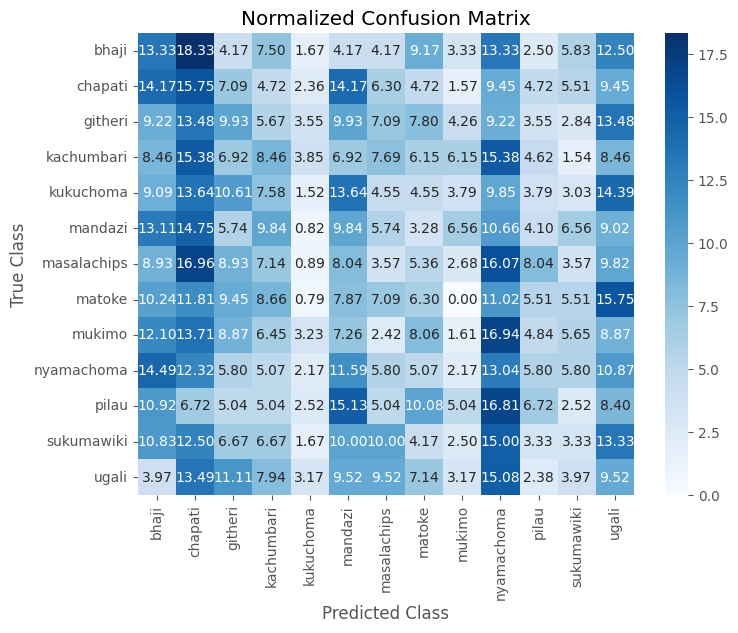

Results saved to /kaggle/working/ft_resnet50_results.csv


In [46]:
if __name__ == '__main__':
    gc.collect()
    main()

In [47]:
zip_folder_with_shutil('/kaggle/working/log_resnet', '/kaggle/working/log_resnet')

## <font style="color:green">8. TensorBoard Log [5 Points]</font>

**Share your TensorBoard scalars logs here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


<font style="color:red">Note:</font> In light of the recent shutdown of tensorboard.dev, we have updated the submission requirements for your project. Instead of sharing a tensorboard.dev link, you are now required to upload your generated TensorBoard event files directly onto the lab. As an alternative, you may also include a screenshot of your TensorBoard output within your Jupyter notebook. This adjustment ensures that your data visualization and model training efforts are thoroughly documented and accessible for evaluation.

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

In [48]:
zip_folder_with_shutil('/kaggle/working/models', '/kaggle/working/models')

## ***References:***

- [GitHub - OpenCV_PyTorch_Project2](https://github.com/RadimKozl/OpenCV_PyTorch_Project2)
- [OpenCV PyTorch Project-2 Classification](https://www.kaggle.com/competitions/opencv-pytorch-classification-project-2)
- [Kaggle Profile](https://www.kaggle.com/radimkzl)